В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/edce80b5bb02479085855b2334b17fc1). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [1]:
import opendatasets as od
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import operator

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

Area under ROC score on Training dataset: 88.26%


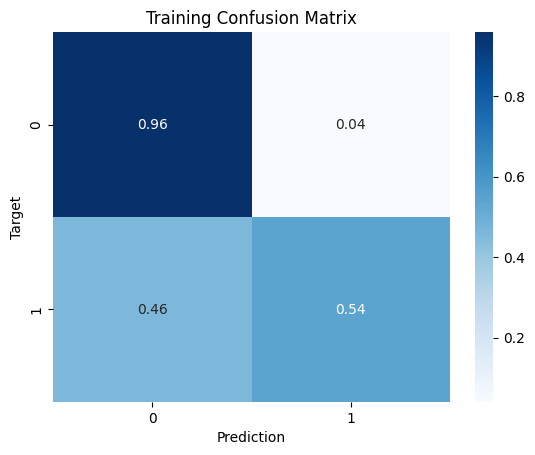

Area under ROC score on Validation dataset: 87.99%


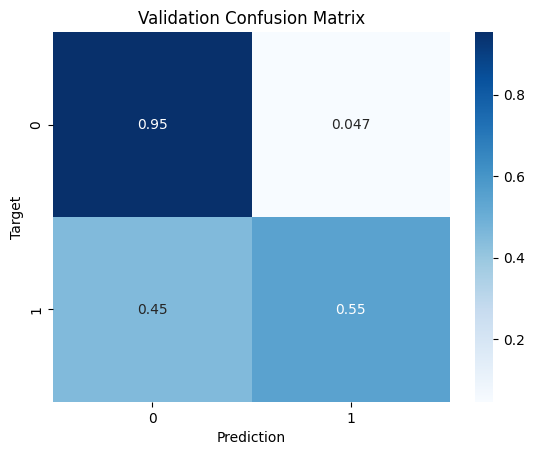

['bank_customer_churn_pred_model.joblib']

In [2]:
raw_df = pd.read_csv('./bank-customer-churn-prediction-dlu-course-c-2/train.csv')

# Видаляємо стовпці, які зайві для моделі
raw_df.drop(['id', 'CustomerId', 'Surname'], axis = 1, inplace = True)

train_df, val_df = train_test_split(raw_df, test_size = 0.25, random_state = 42, stratify = raw_df.Exited)

# Створюємо трен. і вал. набори
input_cols = list(train_df.columns)[:-1]
target_col = list(train_df.columns)[-1]
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include = np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes(include = 'object').columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps = [
    ('scaler', MinMaxScaler())
])


categorical_transformer = Pipeline(steps = [
    ('onehot', OneHotEncoder(sparse = False, handle_unknown = 'ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver = 'liblinear'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name = ''):
    
    preds = model_pipeline.predict(inputs)
    
    # Predict probabilities
    y_pred_proba = model_pipeline.predict_proba(inputs)[:, 1]
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label = 1)
    
    # Compute AUROC
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2%}")
    
    # Confusion matrix
    confusion_matrix_ = confusion_matrix(targets, preds, normalize = 'true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap = 'Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Training')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'bank_customer_churn_pred_model.joblib')


**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

In [3]:
# Створюємо і тренуємо пайплайн з polinomial features

def polynomial_pipeline(deg, numeric_cols, categorical_cols, train_inputs, train_targets):

    numeric_transformer = Pipeline(steps = [
        ('scaler', MinMaxScaler()),
        ('polynom_features', PolynomialFeatures(degree = deg))
    ])

    categorical_transformer = Pipeline(steps = [
    ('onehot', OneHotEncoder(sparse = False, handle_unknown = 'ignore'))
    ])

    # Комбінуємо трансформери для різних типів колонок в один препроцесор
    preprocessor = ColumnTransformer(
        transformers = [
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    # Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
    model_pipeline = Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(solver = 'liblinear'))
    ])

    # Тренуємо пайплайн
    model_pipeline.fit(train_inputs, train_targets)
    
    return model_pipeline

Area under ROC score on Training dataset: 92.11%


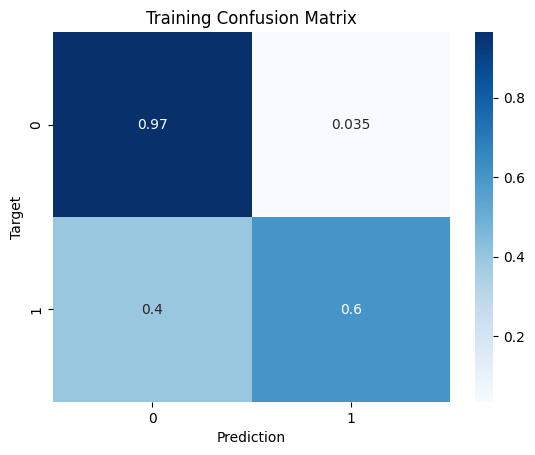

Area under ROC score on Validation dataset: 91.87%


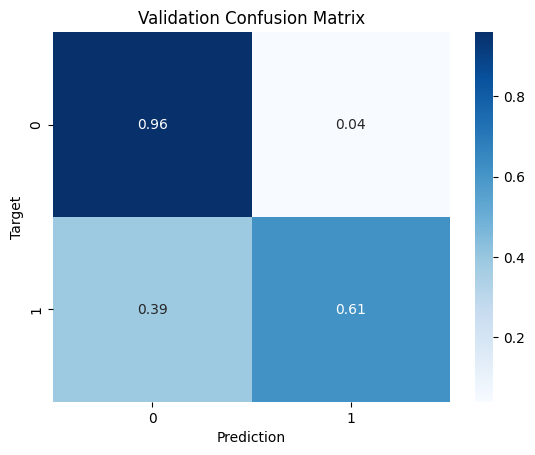

In [4]:
# Тренуємо пайплайн з степенем 2 і оцінюємо модель на тренувальних і валідаційних даних

model_pipeline_deg_2 = polynomial_pipeline(2, numeric_cols, categorical_cols, train_inputs, train_targets)
train_preds_deg_2 = predict_and_plot(model_pipeline_deg_2, train_inputs, train_targets, 'Training')
val_preds_deg_2 = predict_and_plot(model_pipeline_deg_2, val_inputs, val_targets, 'Validation')

**Висновок**:\
Модель з використанням поліноміальними ознак краща за просто логістичну регресію (показник AUROC збільшився з 88,26% до 92,11% на тренувальних даних і з 87,99% до 91,87% – на валідаційних).\
Модель добре генералізує, показник AUROC на валідаційних даних не надто відрізняється від його значення на тренувальних. Немає ні underfit, ні overfit. 

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on Training dataset: 93.31%


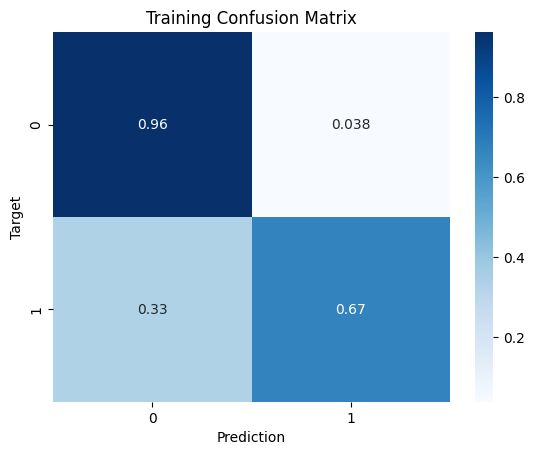

Area under ROC score on Validation dataset: 92.98%


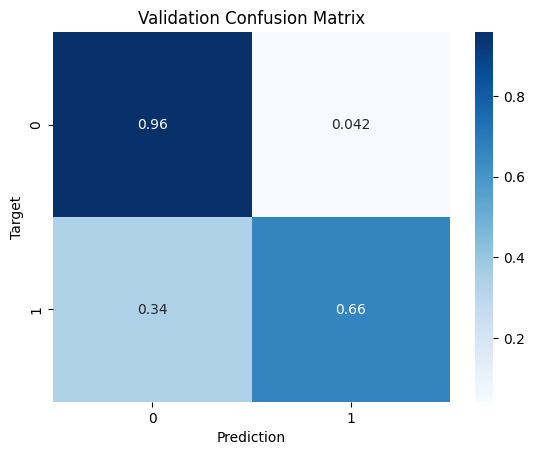

In [5]:
# Тренуємо пайплайн з степенем 4 і оцінюємо модель на тренувальних і валідаційних даних

model_pipeline_deg_4 = polynomial_pipeline(4, numeric_cols, categorical_cols, train_inputs, train_targets)
train_preds_deg_4 = predict_and_plot(model_pipeline_deg_4, train_inputs, train_targets, 'Training')
val_preds_deg_4 = predict_and_plot(model_pipeline_deg_4, val_inputs, val_targets, 'Validation')

**Висновок**:\
Модель зі згенерованими поліноміальними ознаками до степеня 4 краща за попередню. Показник AUROC збільшився і на тренувальному наборі (93,31% проти 92,11%), і на валідаційному (92,98% проти 91,87%). Порівняння значень AUROC на тренувальному і валідаційному наборах вказує на хорошу генералізацію моделі.

In [6]:
# Завантаження тестових даних і знаходження передбачень на них, формування файлу submission

submission_df = pd.read_csv('./bank-customer-churn-prediction-dlu-course-c-2/sample_submission.csv')
test_raw_df = pd.read_csv('./bank-customer-churn-prediction-dlu-course-c-2/test.csv')

test_raw_df.drop(['id', 'CustomerId', 'Surname'], axis = 1, inplace = True)

test_raw_df['Exited'] = model_pipeline_deg_4.predict_proba(test_raw_df)[:, 1]
submission_df.Exited = test_raw_df.Exited
submission_df.to_csv('submission_log_reg_deg_4.csv', index = False)

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [7]:
# Завантажуємо набір даних

regression_data_df = pd.read_csv('./regression_data.csv')

In [8]:
# Перевіряємо який вигляд мають дані в наборі

regression_data_df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482
3,-1.380101,-0.055548,-1.703382,0.074095,1.628616,4.076259
4,-0.072829,-1.514847,-0.846794,0.714000,0.473238,34.879013


In [9]:
# Визначаємо вхідні дані і таргет

inputs = regression_data_df.drop('target', axis = 1)
targets = regression_data_df['target']

# Розділяємо дані на тренувльні і тест
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size = 0.2, random_state = 12)

# Визначаємо числові і категоріальні стовпці
numeric_cols = inputs.select_dtypes(include = np.number).columns.tolist()
categorical_cols = []

In [10]:
# Будуємо функцію для створення і тренування пайплайну

def polynomial_pipeline_lin_reg(deg, numeric_cols, categorical_cols, inputs, targets):

    numeric_transformer = Pipeline(steps = [
        ('scaler', MinMaxScaler()),
        ('polynom_features', PolynomialFeatures(degree = deg))
    ])

    categorical_transformer = Pipeline(steps = [
    ('onehot', OneHotEncoder(sparse = False, handle_unknown = 'ignore'))
    ])

    # Комбінуємо трансформери для різних типів колонок в один препроцесор
    preprocessor = ColumnTransformer(
        transformers = [
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    # Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
    model_pipeline = Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('solver', LinearRegression())
    ])

    # Тренуємо пайплайн
    model_pipeline.fit(inputs, targets)
    
    return model_pipeline

In [11]:
# Тренуємо пайплайн з степенем 5 і знаходимо передбачення на тренувальних і валідаційних даних

model_pipeline_lin_deg_5 = polynomial_pipeline_lin_reg(5, numeric_cols, categorical_cols, X_train, y_train)

train_preds_deg_5 = model_pipeline_lin_deg_5.predict(X_train)
test_preds_deg_5 = model_pipeline_lin_deg_5.predict(X_test)

In [12]:
# Рахуємо точність прогнозу RMSE для X_train
rmse_train = mean_squared_error(y_train, train_preds_deg_5, squared = False)
rmse_train

2.2955777930136813e-13

In [13]:
# Рахуємо точність прогнозу RMSE для X_test
rmse_test = mean_squared_error(y_test, test_preds_deg_5, squared = False)
rmse_test

21.639541714215937

**Висновок**:\
Судячи з RMSE, втрати на тестових даних значно більші за втрати на тренувальних. Це свідчить про перенавчання моделі (overfit).

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [14]:
models = [
    Ridge(alpha = 0.5),
    Lasso(alpha = 0.1),
    ElasticNet(alpha = 0.2, l1_ratio = 0.9)
]

In [15]:
# Будуємо функцію створення та навчання пайплайну моделі з регуляризацією

def pipeline_reg(deg, model, inputs, targets):

    numeric_transformer = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
        ('poly_features', PolynomialFeatures(degree = deg))
    ])

    model_pipeline = Pipeline(steps=[
        ('preprocessor', numeric_transformer),
        ('solver', model)
    ])

    model_pipeline.fit(inputs, targets)

    return model_pipeline

In [16]:
# Будуємо функцію для знаходження передбачення на тренув. і тестових даних, i оцінки точності

def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_metrics = mean_squared_error(y_train, y_train_pred, squared = False).round(6)
    test_metrics = mean_squared_error(y_test, y_test_pred, squared = False).round(6)

    return dict(train = train_metrics, test = test_metrics)

In [17]:
for m in models:
    m_pipeline = pipeline_reg(20, m, X_train, y_train)
    eval_results  = evaluate_model(m_pipeline, X_train, y_train, X_test, y_test)
    print(f'{str(m)}: {eval_results}\n')

Ridge(alpha=0.5): {'train': 4.234087, 'test': 12.990315}

Lasso(alpha=0.1): {'train': 1.140843, 'test': 1.406749}

ElasticNet(alpha=0.2, l1_ratio=0.9): {'train': 9.11019, 'test': 14.808442}



**Висновок 1**:\
Порівнюючи якість останніх моделей з тою, яка була отримана через лінійну регресію вище, найкращою виявилась модель `Lasso` з коефіцієнтом `alpha = 0.1`. Вона показує гірший результат `RMSE` на тренувальних даних (1.14 проти 2.29е-13 для лінійної регресії), зате набагато кращий на тестових (1.4 проти 21.6 для лінійної регресії). Порівняння значення `RMSE` для тренувальних і тестових даних (вони приблизно однакові) вказує на гарну генералізацію цієї моделі.\
Моделі `Ridge` і `ElasticNet` показують значно гірші результати на тренувальних даних і кращі на тестових в порівнянні з лінійною регресією. Порівнюючи `RMSE` для тренувального і тестового наборів кожної з цих двох моделей, можна стверджувати про деякий overfit.

Натренуємо `Lasso` регресію (ту, яка спрацювала найкраще) і перевіримо коефіцієнти (можливо, серед них є ті, що дорівнюють 0). Матимемо відповідь за рахунок чого ця модель найкраще генералізує.

In [18]:
def pipeline_reg_Lasso(deg, alpha, inputs, targets):

    numeric_transformer = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
        ('poly_features', PolynomialFeatures(degree = deg))
    ])

    model_pipeline = Pipeline(steps=[
        ('preprocessor', numeric_transformer),
        ('solver', Lasso())
    ])

    model_pipeline.fit(inputs, targets)

    return model_pipeline

In [19]:
model_pipeline_Lasso = pipeline_reg_Lasso(20, 0.1, X_train, y_train)

In [20]:
coefs_df = pd.DataFrame(model_pipeline_Lasso.named_steps['preprocessor'].named_steps['poly_features'].get_feature_names_out(X_train.columns), columns = ['feature_name'])

In [21]:
coefs_df['value'] = model_pipeline_Lasso.named_steps['solver'].coef_.round(5).flatten()

In [22]:
coefs_df.set_index('feature_name', inplace = True)
coefs_df.sort_values(by = 'value', ascending = False)

,value
feature_name,
feature_4,188.7854
1,0.0000
feature_1^7 feature_3^3 feature_4^8 feature_5,0.0000
feature_1^7 feature_3^4 feature_4^8,0.0000
feature_1^7 feature_3^4 feature_4^7 feature_5,0.0000
...,...
feature_1^3 feature_2 feature_3^6 feature_4 feature_5^5,-0.0000
feature_1^3 feature_2 feature_3^6 feature_5^6,-0.0000
feature_1^3 feature_2 feature_3^5 feature_4^7,0.0000


**Висновок 2**:\
Модель `Lasso` найкраще себе показала, обнуливши всі ознаки крім `feature_4`.